In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
sns.set(font_scale = 1, style = 'darkgrid', rc={'figure.figsize':(7,5)})
pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
#load data for researchers and divisions
df_researchers = pd.read_pickle("Files/Dataframes/researchersFinal.pkl").drop(['ID', 'firstName'], axis = 1).rename(columns = {'AuthorCount': 'ResearcherCount'})
errorResearchers_gender = pd.read_pickle("Files/Dataframes/ResearchersNotFound_wGender.pkl").drop('ID', axis = 1).drop_duplicates(subset = ['SearchName', 'Year', 'SessionType']) #only unique researchers(wrt. year and session type)

#change F to Female, M to Male and ? to Unknown
replacements = {'F': 'Female', 'M': 'Male', '?': 'Unknown'}
df_researchers['Gender'] = df_researchers['Gender'].map(replacements)
errorResearchers_gender['Gender'] = errorResearchers_gender['Gender'].map(replacements)

In [4]:
#remove researchers with negative seniority
#researcher_positiveSeniority = df_researchers[df_researchers.Seniority >= 0].reset_index(drop = True)
researcher_seniorityFilter = df_researchers[(df_researchers.Seniority >= 0)  & (df_researchers.Seniority <= 75)].reset_index(drop = True)
print("Number of researchers deleted, which had negative seniority or very high seniority:", len(df_researchers.SearchName.unique()) - len(researcher_seniorityFilter.SearchName.unique()))

Number of researchers deleted, which had negative seniority or very high seniority: 8553


In [5]:
researchers = researcher_seniorityFilter.drop_duplicates(subset = ['SearchName', 'Year', 'SessionType']) #only unique researchers(wrt. year and session type)
sponsUnitResearchers = researcher_seniorityFilter.drop_duplicates(subset = ['SearchName', 'Year', 'SessionType', 'SponsoringUnits_all']) #unique researchers, also wrt. sponsoring unit
#errorResearchers = pd.read_pickle("Files/Dataframes/errorResearchers_filtered.pkl").drop_duplicates(subset = ['SearchName', 'Year', 'SessionType']) #only unique researchers(wrt. year and session type)
uniqueResearchers = researchers.drop_duplicates(subset='SearchName')

In [6]:
#check the CumulativePaperCount for NaN productivity
researchers[researchers.Productivity.isna()].CumulativePaperCount.unique()

array([0])

In [7]:
#replace NaN values in productivity with 0, since it is because the researchers didn't publish anything at the time
researchers['Productivity'] = researchers.Productivity.fillna(0) 
sponsUnitResearchers['Productivity'] = sponsUnitResearchers.Productivity.fillna(0)

In [8]:
#save researchers and researchers with all assigned sponsoring untis
researchers.to_pickle("Files/Dataframes/researchers.pkl")
sponsUnitResearchers.to_pickle("Files/Dataframes/researchers_sponsoringUnits.pkl")

In [9]:
researchers['log_MaxPaperCount'] = np.log(researchers.MaxPaperCount)
researchers['log_CumulativePaperCount'] = np.log(researchers.CumulativePaperCount)
researchers['log_Productivity'] = np.log(researchers.Productivity)
researchers['log_AuthorCount'] = np.log(researchers.ResearcherCount)

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [10]:
invited = researchers[researchers.SessionType == 'invited']
attendees = researchers[researchers.SessionType == 'attendee']

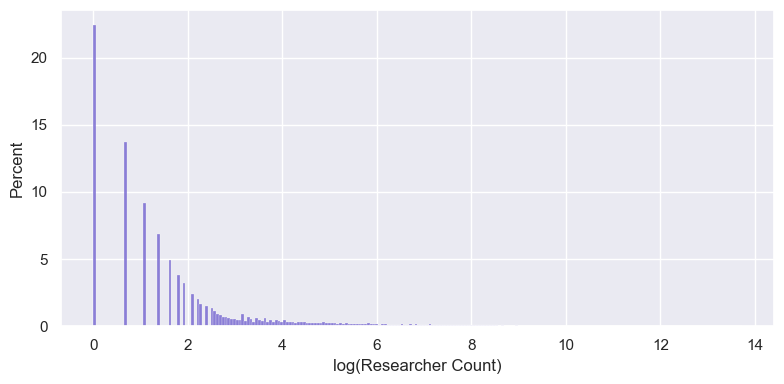

In [11]:
#plt.title('log(Number of results) for each researcher from the API', fontsize = 15)
plt.figure(figsize=(8,4))
sns.histplot(data = researchers, x = 'log_AuthorCount', stat = 'percent', color = 'slateblue')
plt.xlabel('log(Researcher Count)')
plt.tight_layout()
plt.savefig("Figures/authorCount.png", bbox_inches='tight')
plt.show()

### Field

In [12]:
field_API = (uniqueResearchers.groupby('API_Field').count()/(len(uniqueResearchers))*100).sort_values(by ='SearchName', ascending = False).reset_index()
fields_external = (uniqueResearchers.groupby('ExternalField').count()/(len(uniqueResearchers))*100).sort_values(by ='SearchName', ascending = False).reset_index()
fields_model = (uniqueResearchers.groupby('ModelField').count()/(len(uniqueResearchers))*100).sort_values(by ='SearchName', ascending = False).reset_index()

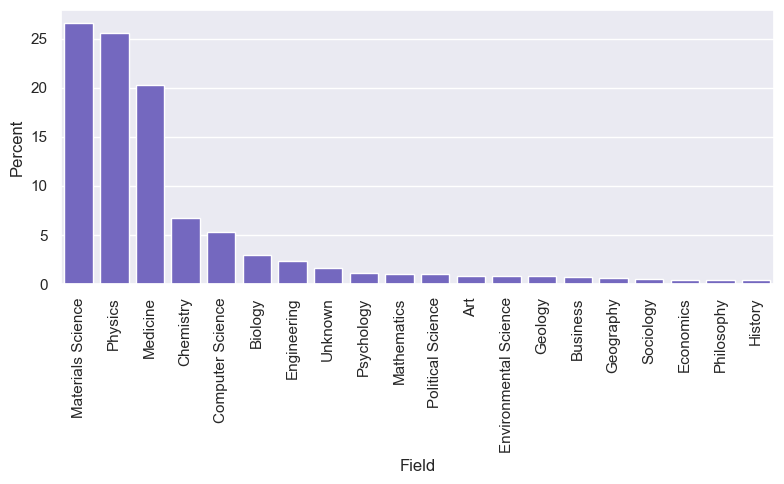

In [13]:
plt.figure(figsize=(8,5))
sns.barplot(data = field_API, x = 'API_Field', y = 'SearchName', color = 'slateblue')
plt.xticks(rotation=90)
plt.xlabel('Field')
plt.ylabel('Percent')
#plt.title("Distribution of the researchers' field of study", fontsize = 15)
plt.tight_layout()
plt.savefig("Figures/fieldPlot_API.png", bbox_inches='tight')
plt.show()

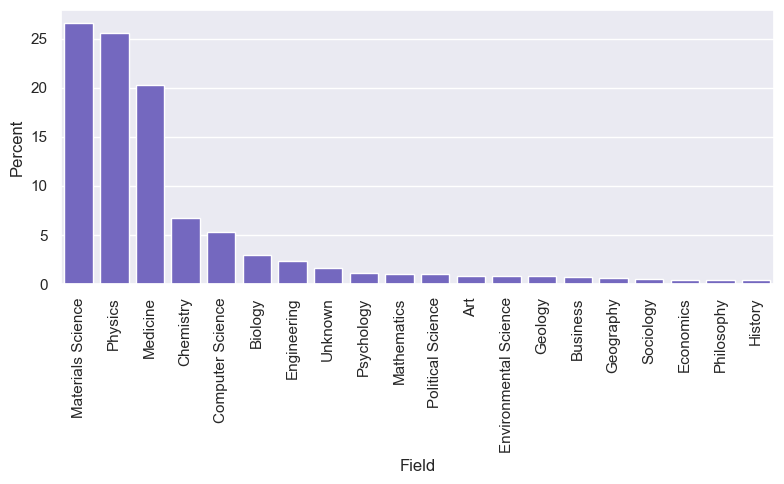

In [14]:
plt.figure(figsize=(8,5))
sns.barplot(data = fields_external, x = 'ExternalField', y = 'SearchName', color = 'slateblue')
plt.xticks(rotation=90)
plt.xlabel('Field')
plt.ylabel('Percent')
#plt.title("Distribution of field from external source", fontsize = 15)
plt.tight_layout()
plt.savefig("Figures/fieldPlot_external.png", bbox_inches='tight')
plt.show()

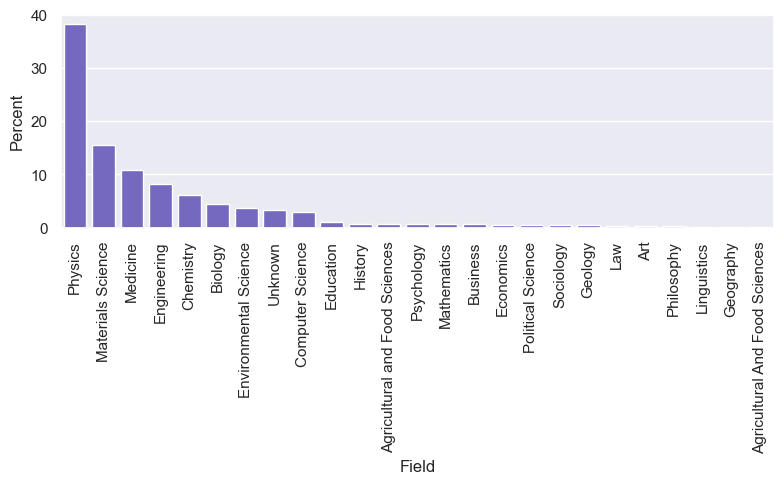

In [15]:
plt.figure(figsize=(8,5))
sns.barplot(data = fields_model, x = 'ModelField', y = 'SearchName', color = 'slateblue')
plt.xticks(rotation=90)
plt.xlabel('Field')
plt.ylabel('Percent')
#plt.title("Distribution of field from classification model", fontsize = 15)
plt.tight_layout()
plt.savefig("Figures/fieldPlot_model.png", bbox_inches='tight')
plt.show()

In [16]:
#create column with 1 if ModelField and ExternalField is the same
uniqueResearchers['SameField'] = np.where(uniqueResearchers['ExternalField'] == uniqueResearchers['ModelField'], 1, 0)

In [17]:
print("Share of researchers with same field from model and external sources:", len(uniqueResearchers[uniqueResearchers.SameField == 1])/len(uniqueResearchers))
print("Share of researchers with different field from model and external sources:", len(uniqueResearchers[uniqueResearchers.SameField == 0])/len(uniqueResearchers))

Share of researchers with same field from model and external sources: 0.5543319612312839
Share of researchers with different field from model and external sources: 0.4456680387687161


### Researchers within medicine

In [18]:
medicineResearchers_API = uniqueResearchers[uniqueResearchers.API_Field == 'Medicine'].reset_index()
medicineResearchers_external = uniqueResearchers[uniqueResearchers.ExternalField == 'Medicine'].reset_index()
medicineResearchers_model = uniqueResearchers[uniqueResearchers.ModelField == 'Medicine'].reset_index()

In [19]:
medicineResearchers_fieldCount_external = medicineResearchers_external.groupby('ExternalFieldCount').count().reset_index()
medicineResearchers_fieldCount_model = medicineResearchers_model.groupby('ModelFieldCount').count().reset_index()

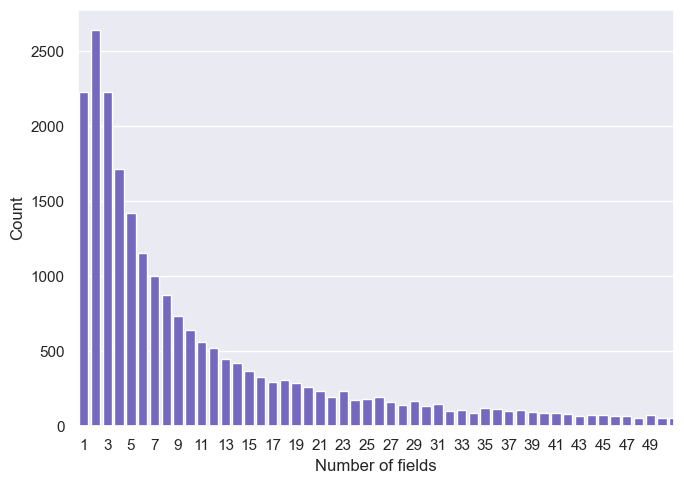

In [20]:
sns.barplot(data = medicineResearchers_fieldCount_external, x = 'ExternalFieldCount', y = 'SearchName', color = 'slateblue')
plt.xlim(-0.5,50)
plt.xticks(np.arange(0,50, 2)) 
plt.xlabel('Number of fields')
plt.ylabel('Count')
#plt.title("Distribution of number of fields(from external sources)", fontsize = 15)
plt.tight_layout()
plt.savefig("Figures/fieldCount_medicine_external.png", bbox_inches='tight')
plt.show()

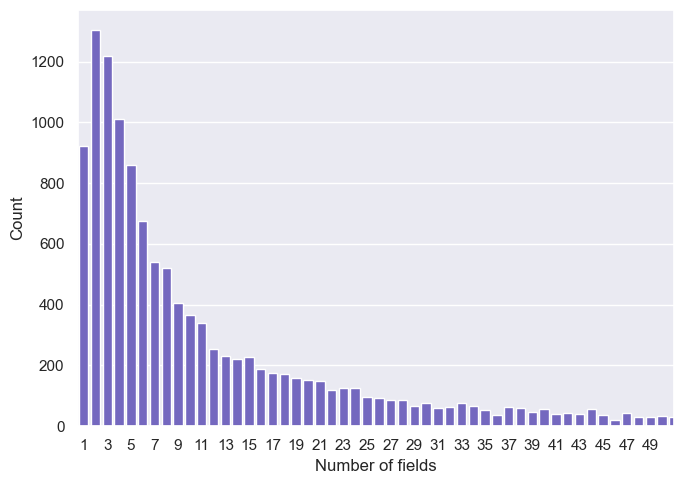

In [21]:
sns.barplot(data = medicineResearchers_fieldCount_model, x = 'ModelFieldCount', y = 'SearchName', color = 'slateblue')
plt.xlim(-0.5,50)
plt.xticks(np.arange(0,50, 2)) 
plt.xlabel('Number of fields')
plt.ylabel('Count')
#plt.title("Distribution of number of fields(from model)", fontsize = 15)
plt.tight_layout()
plt.savefig("Figures/fieldCount_Model.png", bbox_inches='tight')
plt.show()

## Plots

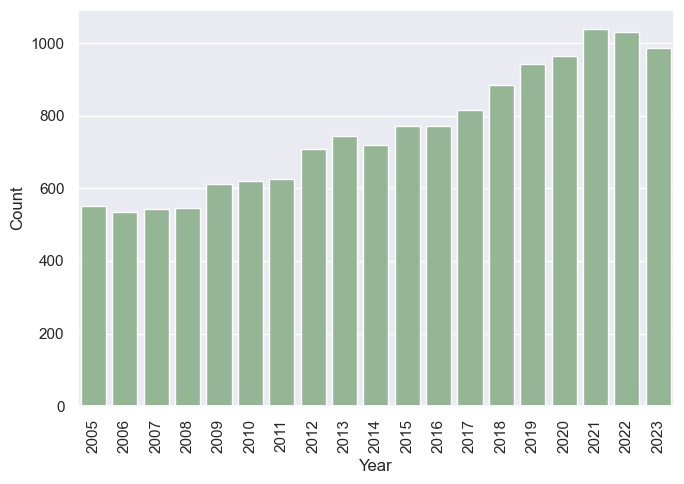

In [22]:
sns.countplot(x = 'Year', data = invited , color = 'darkseagreen')
plt.xticks(rotation=90)
plt.ylabel('Count')
#plt.title('Number of invited speakers per year', fontsize = 15)
plt.tight_layout()
plt.savefig("Figures/invitedSpeakers.png", bbox_inches='tight')
plt.show()

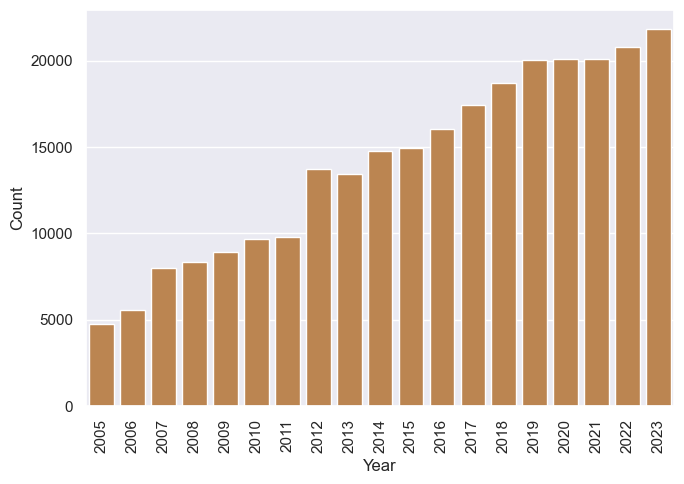

In [23]:
sns.countplot(x = 'Year', data = attendees , color = 'peru')
plt.xticks(rotation=90)
plt.ylabel('Count')
#plt.title('Number of attendees per year', fontsize = 15)
plt.tight_layout()
plt.savefig("Figures/participants.png", bbox_inches='tight')
plt.show()

### Researcher not found

In [24]:
errorResearchersGender_inv = errorResearchers_gender[errorResearchers_gender.SessionType == 'invited']
errorResearchersGender_att = errorResearchers_gender[errorResearchers_gender.SessionType == 'attendee']

In [25]:
#percent errorResearchers of total invited speakers and attendees
errorInvited_percent = ((errorResearchersGender_inv.groupby('Year').count()['SearchName']/(errorResearchersGender_inv.groupby('Year').count()['SearchName'] + invited.groupby('Year').count()['SearchName']))).reset_index()
errorAttendees_percent = ((errorResearchersGender_att.groupby('Year').count()['SearchName']/(errorResearchersGender_att.groupby('Year').count()['SearchName'] + attendees.groupby('Year').count()['SearchName']))).reset_index()

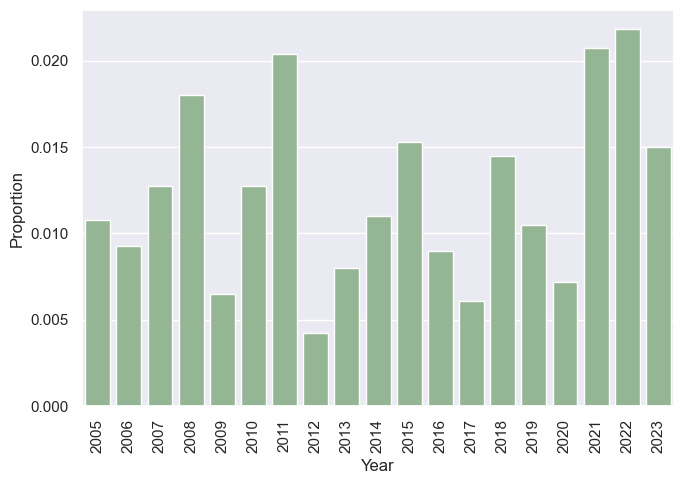

In [26]:
sns.barplot(data = errorInvited_percent, x = 'Year', y = 'SearchName', color = 'darkseagreen')
plt.xticks(rotation=90)
plt.ylabel('Proportion')
#plt.title('Percent invited speakers not found by API of all of the invited speakers', fontsize = 15)
plt.tight_layout()
plt.savefig("Figures/invitedSpeakers_errorResearchers.png", bbox_inches='tight')
plt.show()

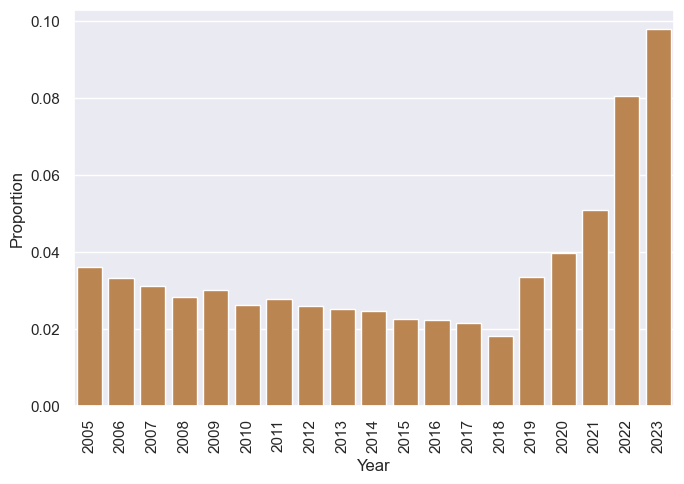

In [27]:
sns.barplot(x = 'Year', data = errorAttendees_percent, y = 'SearchName', color = 'peru')
plt.xticks(rotation=90)
plt.ylabel('Proportion')
#plt.title('Number of attendees per year for researchers not found by the API', fontsize = 15)
plt.tight_layout()
plt.savefig("Figures/participants_errorResearchers.png", bbox_inches='tight')
plt.show()

In [28]:
#calculate gender ratio
errorResearcher_genderRatio_inv = pd.crosstab(index=errorResearchersGender_inv.Year,
                             columns=errorResearchersGender_inv.Gender,
                             normalize="index").rename(columns = {'Female': 'Female invited', 'Male': 'Male invited', 'Unknown': 'Unknown invited'})

errorResearcher_genderRatio_att = pd.crosstab(index=errorResearchersGender_att.Year,
                             columns=errorResearchersGender_att.Gender,
                             normalize="index").rename(columns = {'Female': 'Female attendees', 'Male': 'Male attendees', 'Unknown': 'Unknown attendees'})

In [29]:
#change order of columns
columns_inv = errorResearcher_genderRatio_inv.columns.tolist()
columns_att = errorResearcher_genderRatio_att.columns.tolist()

cols_inv = columns_inv[-1:] +  columns_inv[:2]
cols_att = columns_att[-1:] +  columns_att[:2]

errorResearcher_genderRatio_inv = errorResearcher_genderRatio_inv[cols_inv]
errorResearcher_genderRatio_att = errorResearcher_genderRatio_att[cols_att]

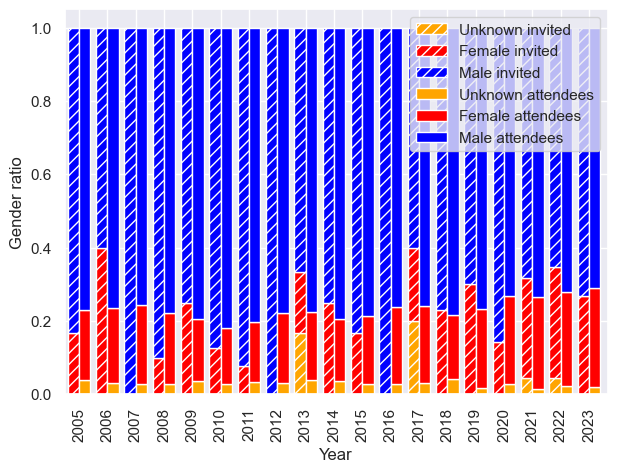

In [30]:
fig, ax = plt.subplots()
errorResearcher_genderRatio_inv.plot(kind='bar', stacked=True, width = 0.4, position = 1, ax = ax, color = ['orange', 'red', 'blue'], hatch = '///')
errorResearcher_genderRatio_att.plot(kind='bar', stacked=True, width = 0.4, position=0, ax = ax, color = ['orange', 'red', 'blue'])
ax.set_xlim(left=-0.5)
plt.legend(loc="upper right", ncol = 1)
#plt.title("Gender ratio per year for researchers not found by API", fontsize = 15)
plt.xlabel("Year")
plt.ylabel("Gender ratio")
plt.savefig("Figures/genderRatio_notFound.png", bbox_inches='tight')
plt.show()

### Sponsoring Units

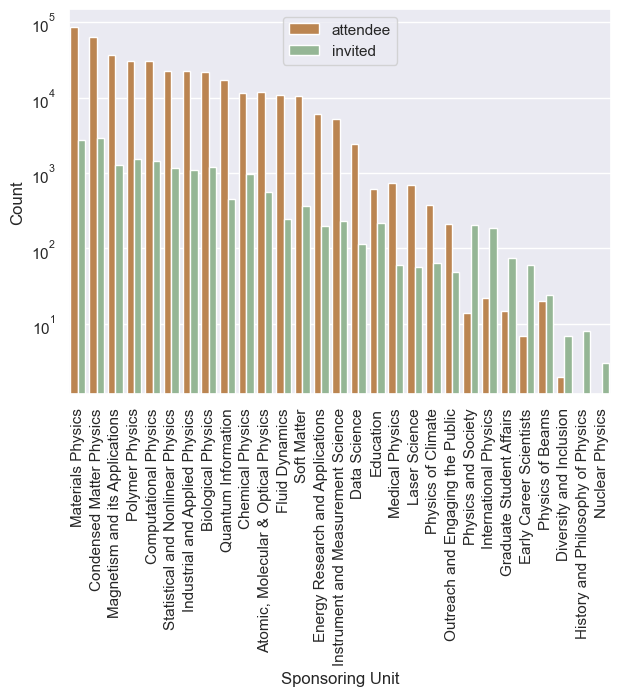

In [31]:
sns.countplot(data = sponsUnitResearchers, x = 'SponsoringUnitName', hue = 'SessionType', palette = ['peru', 'darkseagreen'], order = sponsUnitResearchers.SponsoringUnitName.value_counts().index)
plt.legend(['attendee', 'invited'])
plt.xticks(rotation=90)
plt.yscale('log')
plt.ylabel('Count')
plt.xlabel('Sponsoring Unit')
#plt.title('Total number of researchers per sponsoring unit from 2005 to 2023', fontsize = 15)
plt.savefig("Figures/sponsoringUnits_count_wSessType.png", bbox_inches='tight')
plt.show()

In [32]:
countPerYear = sponsUnitResearchers.groupby(['SponsoringUnitName', 'SessionType', 'Year']).count()['SearchName'].reset_index()
avgCount = countPerYear.groupby(['SponsoringUnitName', 'SessionType']).mean()['SearchName'].reset_index()

In [33]:
#order of sponsoring units for plot
avgPlotOrder = avgCount.groupby('SponsoringUnitName').sum(numeric_only = True).SearchName.sort_values(ascending = False).index

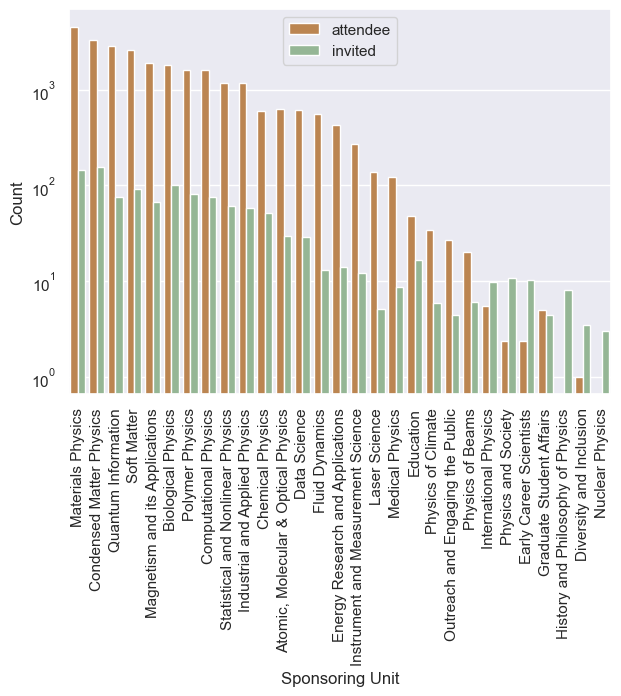

In [34]:
sns.barplot(data = avgCount, x = 'SponsoringUnitName', y = 'SearchName', hue = 'SessionType', palette = ['peru', 'darkseagreen'], order = avgPlotOrder)
plt.legend().set_title('')
plt.xticks(rotation=90)
plt.yscale('log')
plt.ylabel('Count')
plt.xlabel('Sponsoring Unit')
#plt.title('Number of researchers per year for each sponsoring unit from 2005 to 2023', fontsize = 15)
plt.savefig("Figures/sponsoringUnits_avg_wSessType.png", bbox_inches='tight')
plt.show()
#consider having this in appendix

### Gender

In [35]:
#calculate gender ratio
genderRatio_invited = pd.crosstab(index=invited.Year,
                             columns=invited.Gender,
                             normalize="index").rename(columns = {'Female': 'Female invited', 'Male': 'Male invited'})

genderRatio_attendees = pd.crosstab(index=attendees.Year,
                             columns=attendees.Gender,
                             normalize="index").rename(columns = {'Female': 'Female attendees', 'Male': 'Male attendees'})

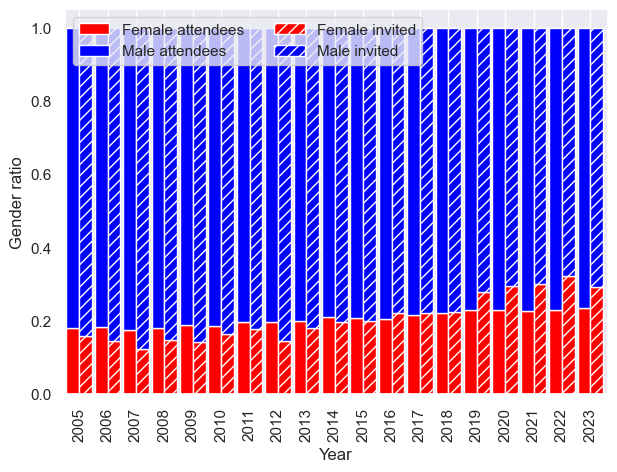

In [36]:
fig, ax = plt.subplots()
genderRatio_attendees.plot(kind='bar', stacked=True, width = 0.45, position = 1, ax = ax, color = ['red', 'blue'])
genderRatio_invited.plot(kind='bar', stacked=True, width = 0.45, position=0, ax = ax, color = ['red', "blue"], hatch = '///')
ax.set_xlim(left=-0.5)
ax.set_xlim(right=len(genderRatio_invited)-0.4)
#ax.set_edgecolor(color = 'black')
plt.legend(loc="upper left", ncol = 2)
#plt.title("Gender ratio per year", fontsize = 15)
plt.xlabel("Year")
plt.ylabel("Gender ratio")
plt.savefig("Figures/genderRatio.png", bbox_inches='tight')
plt.show()

In [37]:
sponsUnit_inv = sponsUnitResearchers[sponsUnitResearchers.SessionType == 'invited']
sponsUnit_att = sponsUnitResearchers[sponsUnitResearchers.SessionType == 'attendee']

#calculate gender ratio
genderRatio_sponsUnit_inv = pd.crosstab(index = sponsUnit_inv.SponsoringUnitName, columns = sponsUnit_inv.Gender, 
            normalize = 'index').rename(columns = {'Female': 'Female invited', 'Male': 'Male invited'})

genderRatio_sponsUnit_att = pd.crosstab(index = sponsUnit_att.SponsoringUnitName, columns = sponsUnit_att.Gender, 
            normalize = 'index').rename(columns = {'Female': 'Female attendees', 'Male': 'Male attendees'})

In [38]:
#order of sponsoring units for plot
unitOrder = sponsUnitResearchers.SponsoringUnitName.value_counts().index
invUnits = genderRatio_sponsUnit_inv.index
attUnits = genderRatio_sponsUnit_att.index
invUnitsOrder = unitOrder.intersection(invUnits)
attUnitsOrder = unitOrder.intersection(attUnits)

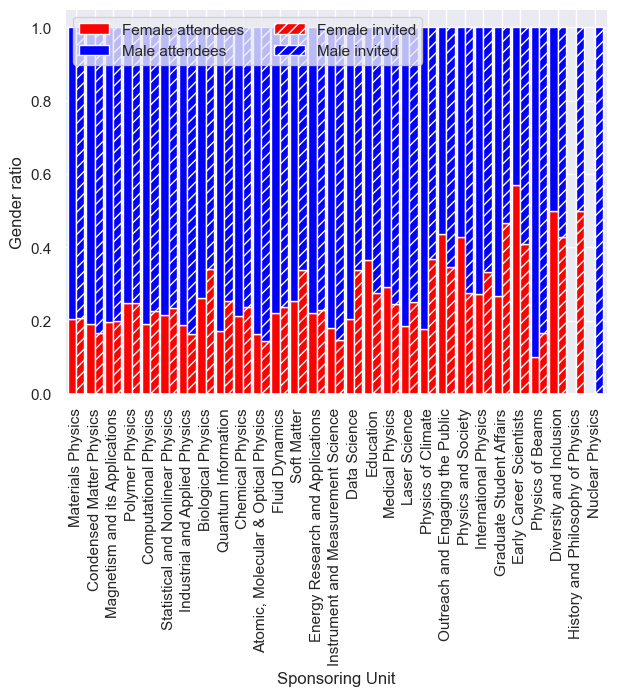

In [39]:
fig, ax = plt.subplots()
genderRatio_sponsUnit_att.loc[attUnitsOrder].plot(kind='bar', stacked=True, width = 0.45, position = 1, ax = ax, color = ['red', 'blue'])
genderRatio_sponsUnit_inv.loc[invUnitsOrder].plot(kind='bar', stacked=True, width = 0.45, position=0, ax = ax, color = ['red', "blue"], hatch = '///')
ax.set_xlim(left=-0.6)
ax.set_xlim(right=len(genderRatio_sponsUnit_inv)-0.3)
plt.legend(loc="upper left", ncol = 2)
#plt.title("Gender ratio for sponsoring units", fontsize = 15)
plt.xlabel("Sponsoring Unit")
plt.ylabel("Gender ratio")
plt.savefig("Figures/genderRatio_sponsoringUnits.png", bbox_inches='tight')
plt.show()

In [40]:
#create function for yearly gender ratio
def yearlyGenderRatio_units(df, sponsoringUnit):
    df_inv = df[(df.SessionType == 'invited') & (df.SponsoringUnitName == sponsoringUnit)]
    df_att = df[(df.SessionType == 'attendee') & (df.SponsoringUnitName == sponsoringUnit)]
    
    df_genderRatio_inv = pd.crosstab(index = df_inv.Year, columns = df_inv.Gender, 
                             normalize = 'index').rename(columns = {'Female': 'Female invited', 
                                                                    'Male': 'Male invited'})
    df_genderRatio_att = pd.crosstab(index = df_att.Year, columns = df_att.Gender, 
                             normalize = 'index').rename(columns = {'Female': 'Female attendee', 
                                                                    'Male': 'Male attendee'})
    return df_genderRatio_inv, df_genderRatio_att

In [41]:
def plotYearlyGenderRatio_units(df, sponsoringUnit):
    genderRatio_inv, genderRatio_att = yearlyGenderRatio_units(df, sponsoringUnit)
    
    fig, ax = plt.subplots()
    genderRatio_att.plot(kind='bar', stacked=True, width = 0.45, position = 1, ax = ax, color = ['red', 'blue'])
    genderRatio_inv.plot(kind='bar', stacked=True, width = 0.45, position=0, ax = ax, color = ['red', "blue"], hatch = '///')
    ax.set_xlim(left=-0.5)
    ax.set_xlim(right=len(genderRatio_inv)-0.4)
    plt.legend(loc="upper left", ncol = 2)
    plt.title("Gender ratio per year for " + sponsoringUnit, fontsize = 15)
    plt.ylabel("Gender ratio")
    plt.savefig("Figures/genderRatio_" + sponsoringUnit.replace(" ", "_") + ".png", bbox_inches='tight')
    plt.show()      

In [42]:
def selectSponsoringUnits(df): #select only those that have invited and attendees each year
    selectedSponsoringUnits = []
    sponsoringUnitList = df.SponsoringUnitName.unique().tolist()
    for i in sponsoringUnitList:
        df_sponsor = df[df.SponsoringUnitName == i]
        nYears = len(df[df.SponsoringUnitName == i].Year.unique())
        table = df_sponsor.groupby(['Year', 'SessionType']).count()
        if len(table) == 2*nYears:
            if len(df_sponsor) >= 12000: #need to be at least 5 % of data
                selectedSponsoringUnits.append(i)
    return selectedSponsoringUnits


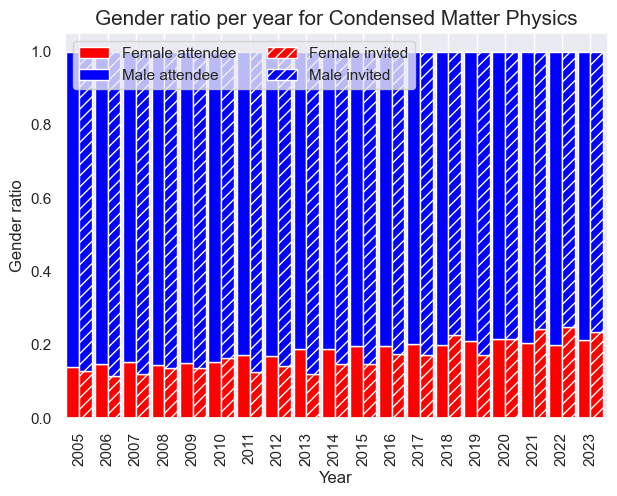

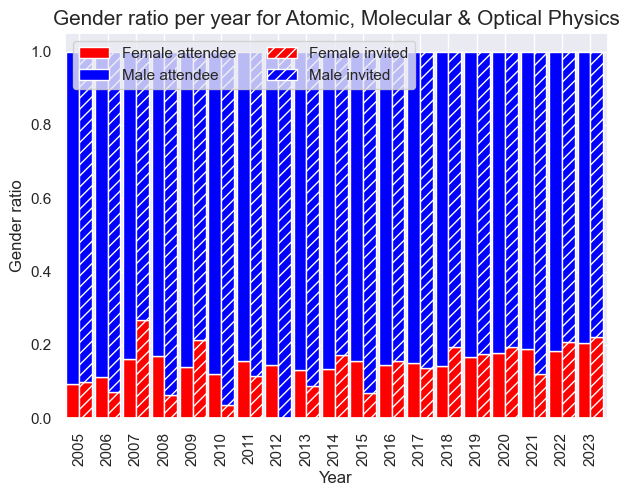

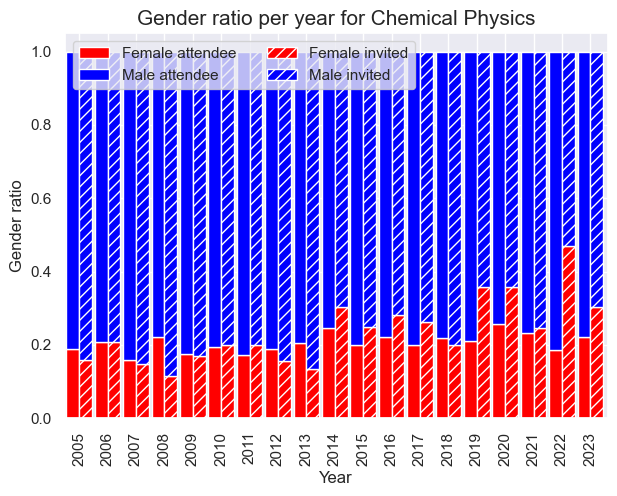

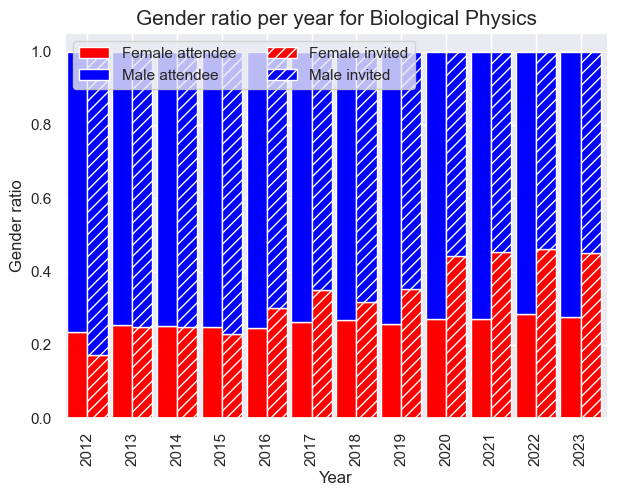

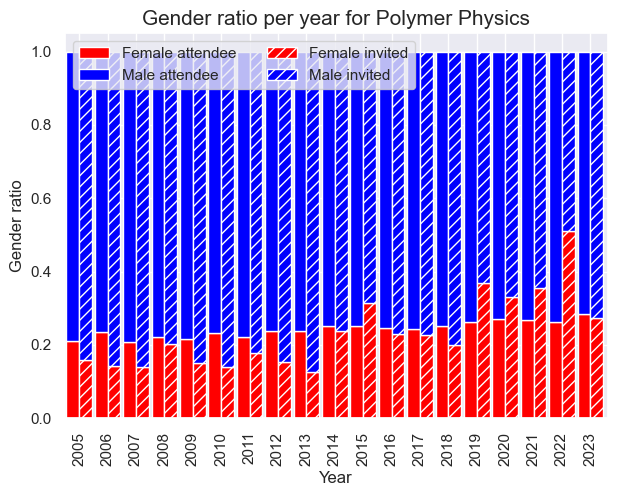

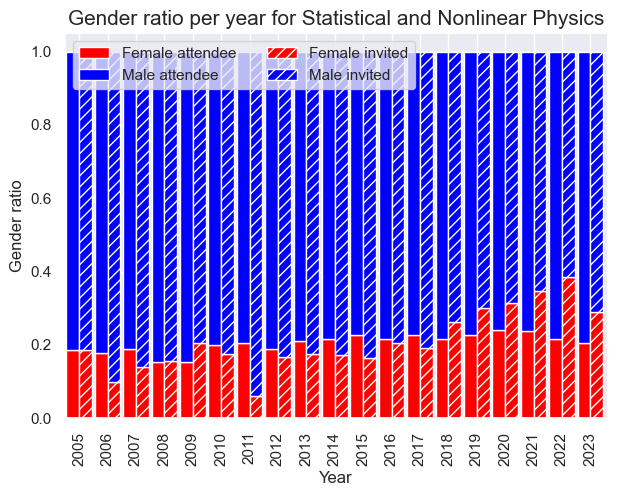

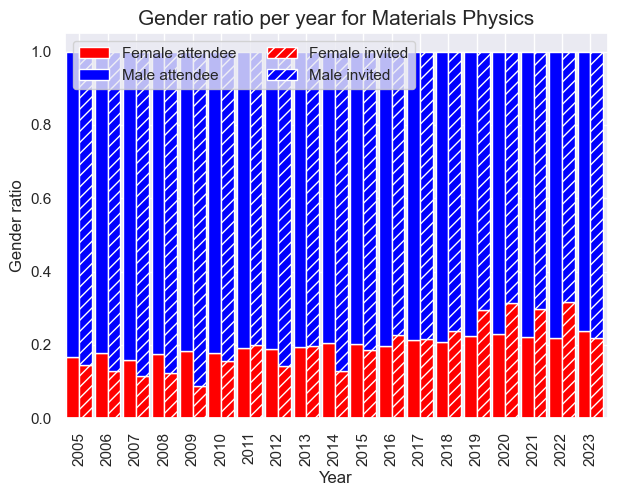

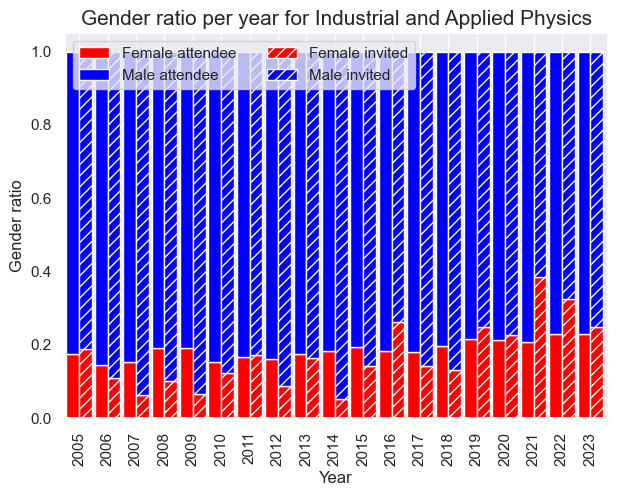

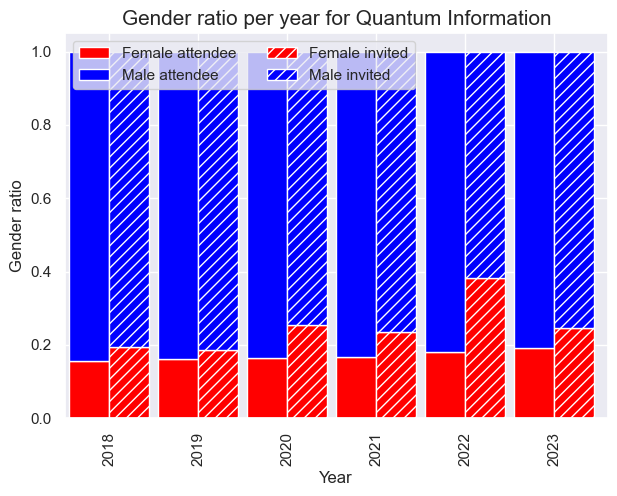

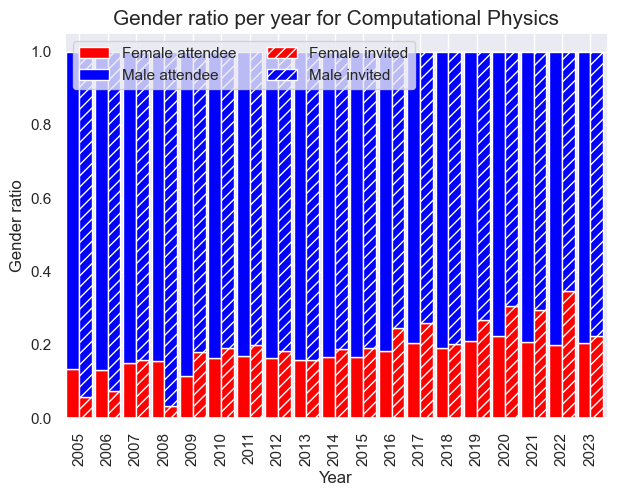

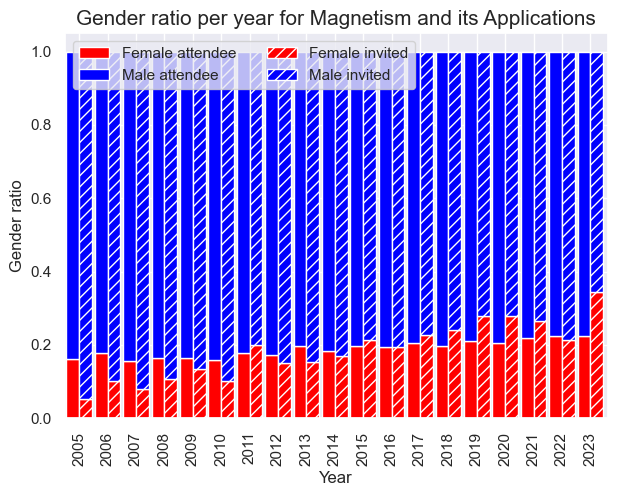

In [43]:
#plot yearly gender ratio for sponsoring units
selectedSponsoringUnits = selectSponsoringUnits(sponsUnitResearchers)
for i in selectedSponsoringUnits:
    plotYearlyGenderRatio_units(sponsUnitResearchers, i)

In [44]:
invitedSpeakers_genderCount = invited.groupby(['Year', 'Gender']).count().reset_index()
participants_genderCount = attendees.groupby(['Year', 'Gender']).count().reset_index()

In [45]:
years = invited.Year.unique().tolist()

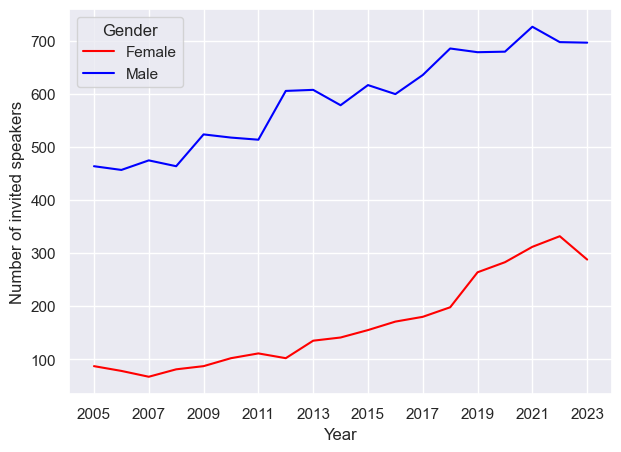

In [46]:
sns.lineplot(data = invitedSpeakers_genderCount, x = 'Year', y = 'Name', hue = 'Gender',  palette=['red', 'blue'])
plt.xticks(np.arange(min(years), max(years)+1, 2.0))
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of invited speakers", fontsize=12)
#plt.title("Number of invited speakers per year", fontsize = 15)
plt.savefig("Figures/nInvitedSpeakers.png", bbox_inches='tight')
plt.show()

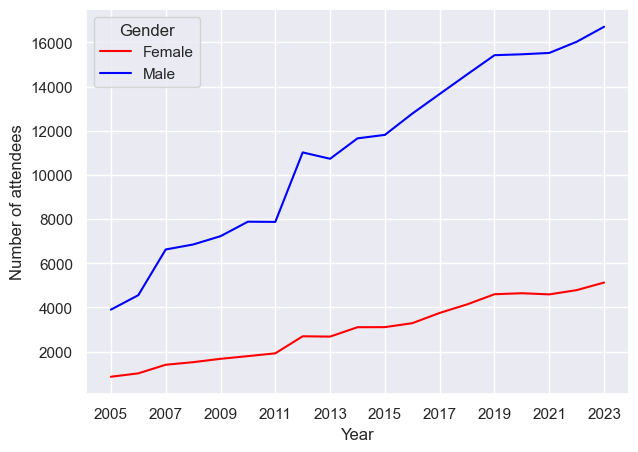

In [47]:
sns.lineplot(data = participants_genderCount, x = 'Year', y = 'Name', hue = 'Gender',  palette=["red", "blue"])
plt.xticks(np.arange(min(years), max(years)+1, 2.0))
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of attendees", fontsize=12)
#plt.title("Number of attendees per year", fontsize = 15)
plt.savefig("Figures/nParticipants.png", bbox_inches='tight')
plt.show()

In [48]:
#calculate percentage increase
invitedSpeakers_genderCount_F = invitedSpeakers_genderCount[invitedSpeakers_genderCount.Gender == 'Female']
invitedSpeakers_genderCount_M = invitedSpeakers_genderCount[invitedSpeakers_genderCount.Gender == 'Male']
participants_genderCount_F = participants_genderCount[participants_genderCount.Gender == 'Female']
participants_genderCount_M = participants_genderCount[participants_genderCount.Gender == 'Male']

#calculate and add the increase
invitedSpeakers_genderCount_F['Increase'] = invitedSpeakers_genderCount_F.SearchName.pct_change().fillna(0) * 100
invitedSpeakers_genderCount_M['Increase'] = invitedSpeakers_genderCount_M.SearchName.pct_change().fillna(0) * 100
participants_genderCount_F['Increase'] = participants_genderCount_F.SearchName.pct_change().fillna(0) * 100
participants_genderCount_M['Increase'] = participants_genderCount_M.SearchName.pct_change().fillna(0) * 100

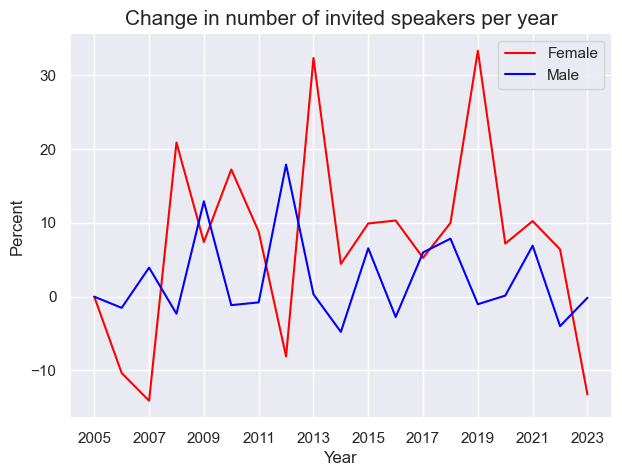

In [49]:
sns.lineplot(data = invitedSpeakers_genderCount_F, x = 'Year', y = 'Increase', color = 'red', label = 'Female')
sns.lineplot(data = invitedSpeakers_genderCount_M, x = 'Year', y = 'Increase', color = 'blue', label = 'Male')
plt.xticks(np.arange(min(years), max(years)+1, 2.0))
plt.ylabel("Percent", fontsize=12)
plt.title("Change in number of invited speakers per year", fontsize = 15)
plt.savefig("Figures/invited_change.png", bbox_inches='tight')
plt.show()

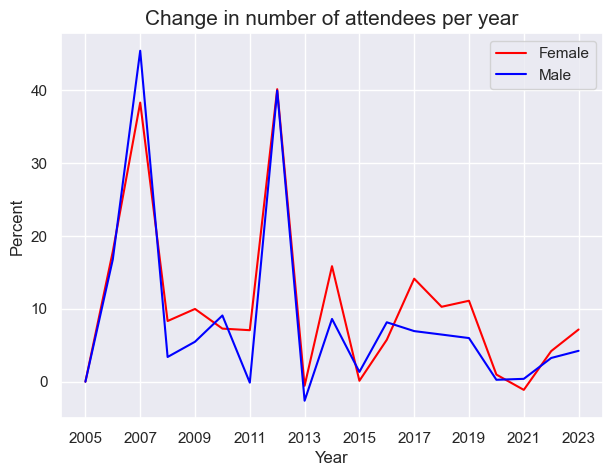

In [50]:
sns.lineplot(data = participants_genderCount_F, x = 'Year', y = 'Increase', color = 'red', label = 'Female')
sns.lineplot(data = participants_genderCount_M, x = 'Year', y = 'Increase', color = 'blue', label = 'Male')
plt.xticks(np.arange(min(years), max(years)+1, 2.0))
plt.ylabel("Percent", fontsize=12)
plt.title("Change in number of attendees per year", fontsize = 15)
plt.savefig("Figures/attendees_change.png", bbox_inches='tight')
plt.show()

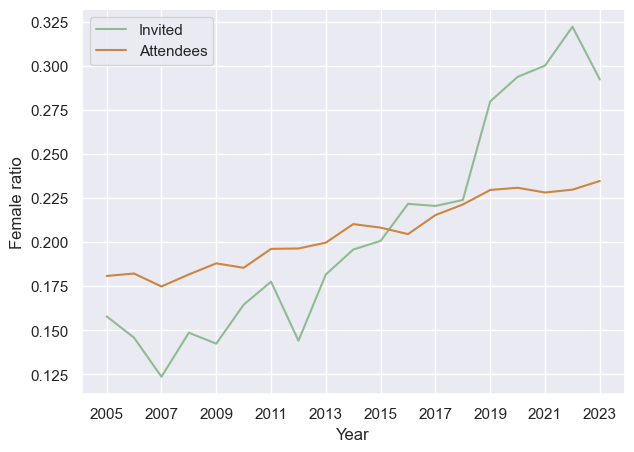

In [51]:
sns.lineplot(data = genderRatio_invited.reset_index(), x = 'Year', y = 'Female invited', color = 'darkseagreen', label = 'Invited')
sns.lineplot(data = genderRatio_attendees.reset_index(), x = 'Year', y = 'Female attendees', color = 'peru', label = 'Attendees')
plt.xticks(np.arange(min(years), max(years)+1, 2.0))
plt.xlabel("Year", fontsize=12)
plt.ylabel("Female ratio", fontsize=12)
#plt.title("Ratio of female researchers per year", fontsize = 15)
plt.savefig("Figures/FemaleRatio.png", bbox_inches='tight')
plt.show()

In [52]:
sponsoringUnit = 'Atomic, Molecular & Optical Physics'
inv, att = yearlyGenderRatio_units(sponsUnitResearchers, sponsoringUnit)

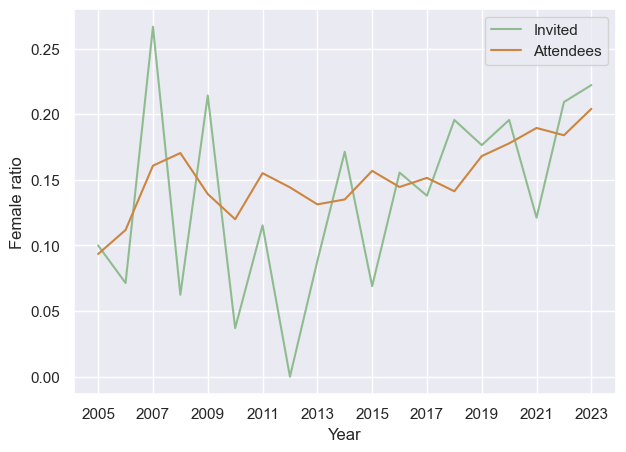

In [53]:
sns.lineplot(data = inv.reset_index(), x = 'Year', y = 'Female invited', color = 'darkseagreen', label = 'Invited')
sns.lineplot(data = att.reset_index(), x = 'Year', y = 'Female attendee', color = 'peru', label = 'Attendees')
plt.xticks(np.arange(min(years), max(years)+1, 2.0))
plt.xlabel("Year", fontsize=12)
plt.ylabel("Female ratio", fontsize=12)
#plt.title(sponsoringUnit, fontsize = 15)
plt.savefig("Figures/FemaleRatio_Atomic.png", bbox_inches='tight')
plt.show()

In [54]:
sponsoringUnit = 'Polymer Physics'
inv, att = yearlyGenderRatio_units(sponsUnitResearchers, sponsoringUnit)

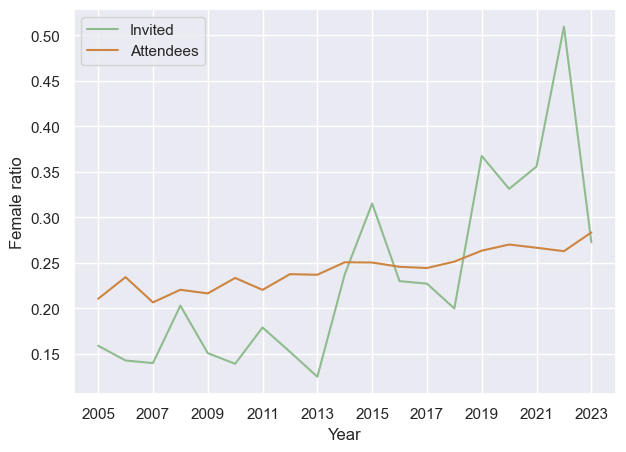

In [55]:
sns.lineplot(data = inv.reset_index(), x = 'Year', y = 'Female invited', color = 'darkseagreen', label = 'Invited')
sns.lineplot(data = att.reset_index(), x = 'Year', y = 'Female attendee', color = 'peru', label = 'Attendees')
plt.xticks(np.arange(min(years), max(years)+1, 2.0))
plt.xlabel("Year", fontsize=12)
plt.ylabel("Female ratio", fontsize=12)
#plt.title(sponsoringUnit, fontsize = 15)
plt.savefig("Figures/FemaleRatio_Polymer.png", bbox_inches='tight')
plt.show()

In [56]:
sponsoringUnit = 'Computational Physics'
inv, att = yearlyGenderRatio_units(sponsUnitResearchers, sponsoringUnit)

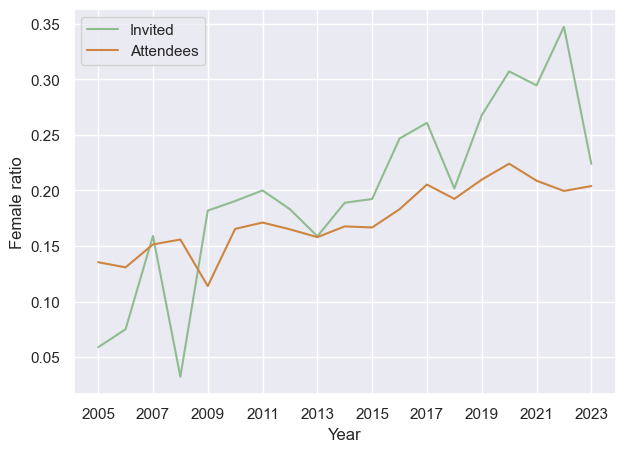

In [57]:
sns.lineplot(data = inv.reset_index(), x = 'Year', y = 'Female invited', color = 'darkseagreen', label = 'Invited')
sns.lineplot(data = att.reset_index(), x = 'Year', y = 'Female attendee', color = 'peru', label = 'Attendees')
plt.xticks(np.arange(min(years), max(years)+1, 2.0))
plt.xlabel("Year", fontsize=12)
plt.ylabel("Female ratio", fontsize=12)
#plt.title(sponsoringUnit, fontsize = 15)
plt.savefig("Figures/FemaleRatio_Computational.png", bbox_inches='tight')
plt.show()

### Publications

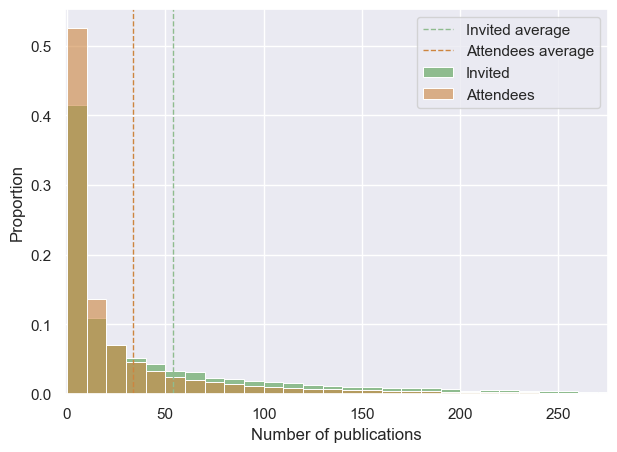

In [58]:
sns.histplot(data = invited, x = 'CumulativePaperCount', stat = 'proportion', color = 'darkseagreen', label = 'Invited', alpha = 1, binwidth = 10)
sns.histplot(data = attendees, x = 'CumulativePaperCount', stat = 'proportion', color = 'peru', label = 'Attendees', alpha = 0.6, binwidth = 10)
plt.axvline(x = invited.CumulativePaperCount.mean(), color = 'darkseagreen', linewidth = 1, label = 'Invited average').set_linestyle("--")
plt.axvline(x = attendees.CumulativePaperCount.mean(), color = 'peru', linewidth = 1, label = 'Attendees average').set_linestyle("--")
plt.legend()
plt.xlim(-1, 275)
plt.xlabel("Number of publications", fontsize=12)
#plt.title("Distribution of publications for invited speakers and attendees", fontsize = 15)
plt.savefig("Figures/publications_dist_all.png", bbox_inches='tight')
plt.show()

In [59]:
print(invited.CumulativePaperCount.min())
print(attendees.CumulativePaperCount.min())
print(invited.CumulativePaperCount.max())
print(attendees.CumulativePaperCount.max())

0
0
494
500


In [60]:
maleInv = invited[invited.Gender == 'Male']
femaleInv = invited[invited.Gender == 'Female']
maleAtt = attendees[attendees.Gender == 'Male']
femaleAtt = attendees[attendees.Gender == 'Female']

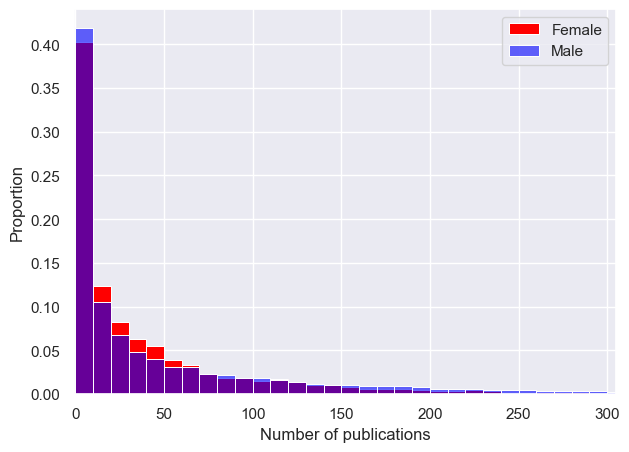

In [61]:
#same plot as the one above
sns.histplot(data = femaleInv, x = 'CumulativePaperCount', stat = 'proportion', color = 'red', label = 'Female', alpha = 1, binwidth = 10)
sns.histplot(data = maleInv, x = 'CumulativePaperCount', stat = 'proportion', color = 'blue', label = 'Male', alpha = 0.6, binwidth = 10)
plt.legend()
plt.xlim(-1, 305)
plt.xlabel("Number of publications", fontsize=12)
#plt.title("Distribution of publications for invited speakers", fontsize = 15)
plt.savefig("Figures/publications_dist_invited.png", bbox_inches='tight')
plt.show()

In [62]:
print(femaleInv.CumulativePaperCount.min())
print(maleInv.CumulativePaperCount.min())
print(femaleInv.CumulativePaperCount.max())
print(maleInv.CumulativePaperCount.max())

0
0
482
494


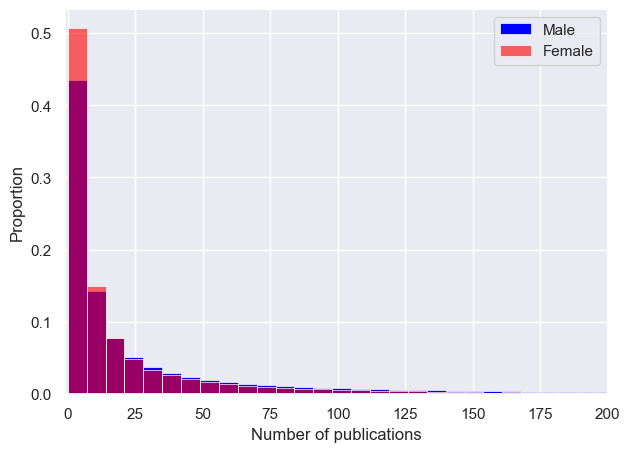

In [63]:
sns.histplot(data = maleAtt, x = 'CumulativePaperCount', stat = 'proportion', color = 'blue', label = 'Male', binwidth = 7, alpha = 1)
sns.histplot(data = femaleAtt, x = 'CumulativePaperCount', stat = 'proportion', color = 'red', label = 'Female', binwidth = 7, alpha = 0.6)
plt.legend()
plt.xlim(-1, 200)
plt.xlabel("Number of publications", fontsize=12)
#plt.title("Distribution of publications for attendees", fontsize = 15)
plt.savefig("Figures/publications_dist_attendees.png", bbox_inches='tight')
plt.show()

In [64]:
print(femaleAtt.CumulativePaperCount.min())
print(maleAtt.CumulativePaperCount.min())
print(femaleAtt.CumulativePaperCount.max())
print(maleAtt.CumulativePaperCount.max())

0
0
500
500


In [65]:
capprops = dict(color = 'black', alpha = 1)
medianprops = dict(color = 'black', alpha = 1)
whiskerprops = dict(color = 'black', alpha = 1)

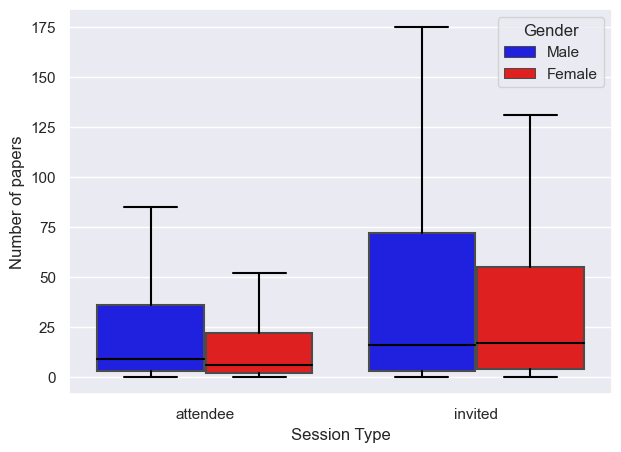

In [66]:
#boxplot of cumulative paper count 
sns.boxplot(data=researchers, x="SessionType", y="CumulativePaperCount", hue='Gender', palette = ['blue', 'red'], showfliers=False, medianprops=medianprops, whiskerprops = whiskerprops, capprops = capprops) 

plt.xlabel("Session Type", fontsize=12)
plt.ylabel("Number of papers", fontsize=12)
#plt.title("Boxplot of number of published papers at time of conference", fontsize = 15)
plt.savefig("Figures/cumulativePaperCount_boxplot", bbox_inches='tight')
plt.show()

In [67]:
print(femaleAtt.quantile([.25, .5, 0.75], numeric_only = True)['CumulativePaperCount'])
print(maleAtt.quantile([.25, .5, 0.75], numeric_only = True)['CumulativePaperCount'])

0.25     2.0
0.50     6.0
0.75    22.0
Name: CumulativePaperCount, dtype: float64
0.25     3.0
0.50     9.0
0.75    36.0
Name: CumulativePaperCount, dtype: float64


In [68]:
print(femaleInv.quantile([.25, .5, 0.75], numeric_only = True)['CumulativePaperCount'])
print(maleInv.quantile([.25, .5, 0.75], numeric_only = True)['CumulativePaperCount'])

0.25     4.0
0.50    17.0
0.75    55.0
Name: CumulativePaperCount, dtype: float64
0.25     3.0
0.50    16.0
0.75    72.0
Name: CumulativePaperCount, dtype: float64


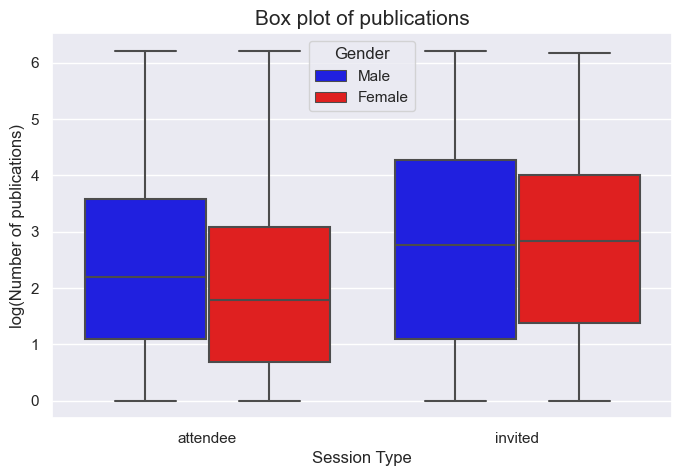

In [69]:
#boxplot of log_maxPaperCount
plt.figure(figsize=(8, 5))
sns.boxplot(data=researchers, x="SessionType", y="log_CumulativePaperCount", hue='Gender', palette = ['blue', 'red'])
plt.xlabel("Session Type", fontsize=12)
plt.ylabel("log(Number of publications)", fontsize=12)
plt.title("Box plot of publications", fontsize = 15)
plt.savefig("Figures/logPaperCount_boxplot", bbox_inches='tight')
plt.show()

In [70]:
bins = np.arange(0, 35, 5).tolist()
bins.append(float("inf"))
labels = ['1-5', '6-10', '11-15', '16-20', '21-25', '26-30', '> 30']

In [71]:
#create seniority categories
researchers['Seniority_cat'] = pd.cut(researchers['Seniority'], bins = bins, labels = labels)

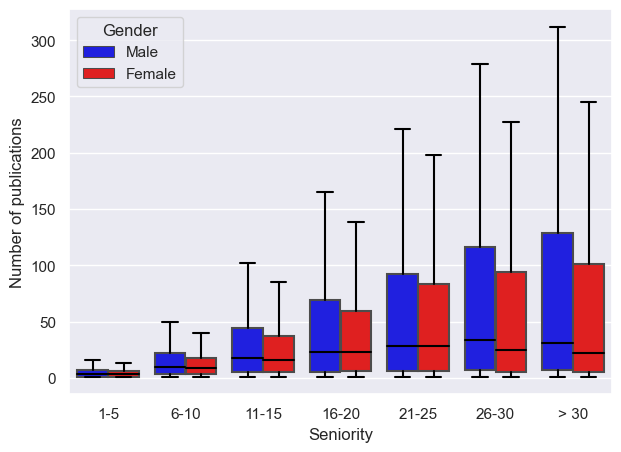

In [72]:
sns.boxplot(data=researchers , x="Seniority_cat", y='CumulativePaperCount', hue='Gender', palette = ['blue', 'red'], showfliers=False, medianprops=medianprops, whiskerprops = whiskerprops, capprops = capprops)
plt.xlabel("Seniority", fontsize=12)
plt.ylabel("Number of publications", fontsize=12)
#plt.title("Distribution of publications by seniority", fontsize = 15)
#plt.legend(loc="lower right")
plt.savefig("Figures/paperCount_Seniority_boxplot", bbox_inches='tight')
plt.show()

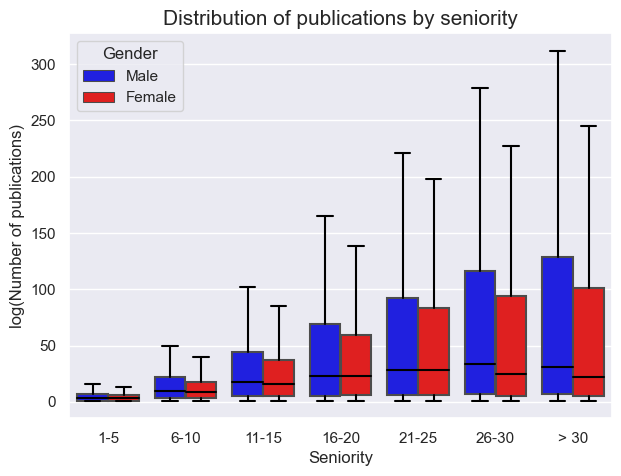

In [73]:
sns.boxplot(data=researchers , x="Seniority_cat", y='CumulativePaperCount', hue='Gender', palette = ['blue', 'red'], showfliers = False, medianprops=medianprops, whiskerprops = whiskerprops, capprops = capprops)
plt.xlabel("Seniority", fontsize=12)
plt.ylabel("log(Number of publications)", fontsize=12)
plt.title("Distribution of publications by seniority", fontsize = 15)
#plt.legend(loc="lower right")
plt.savefig("Figures/paperCount_Seniority_boxplot", bbox_inches='tight')
plt.show()

In [74]:
invited = researchers[researchers.SessionType == 'invited']
attendees = researchers[researchers.SessionType == 'attendee']

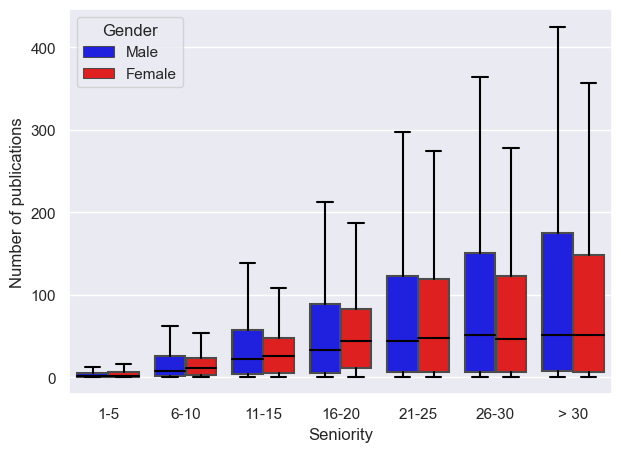

In [75]:
sns.boxplot(data=invited , x="Seniority_cat", y='CumulativePaperCount', hue='Gender', palette = ['blue', 'red'], showfliers = False, medianprops=medianprops, whiskerprops = whiskerprops, capprops = capprops)
plt.xlabel("Seniority", fontsize=12)
plt.ylabel("Number of publications", fontsize=12)
#plt.title("Distribution of publications by seniority for invited speakers", fontsize = 15)
#plt.legend(loc="lower right")
plt.savefig("Figures/paperCount_SeniorityInv_boxplot", bbox_inches='tight')
plt.show()

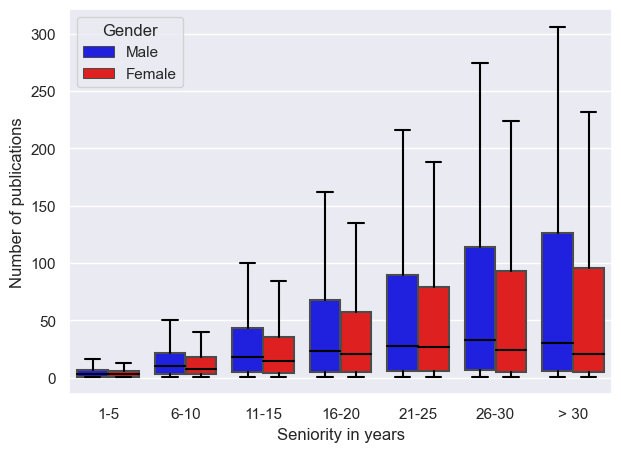

In [76]:
sns.boxplot(data=attendees , x="Seniority_cat", y='CumulativePaperCount', hue='Gender', palette = ['blue', 'red'], showfliers = False, medianprops=medianprops, whiskerprops = whiskerprops, capprops = capprops)
plt.xlabel("Seniority in years", fontsize=12)
plt.ylabel("Number of publications", fontsize=12)
#plt.title("Distribution of publications by seniority for attendees", fontsize = 15)
#plt.legend(loc="lower right")
plt.savefig("Figures/paperCount_SeniorityAtt_boxplot", bbox_inches='tight')
plt.show()

### Seniority

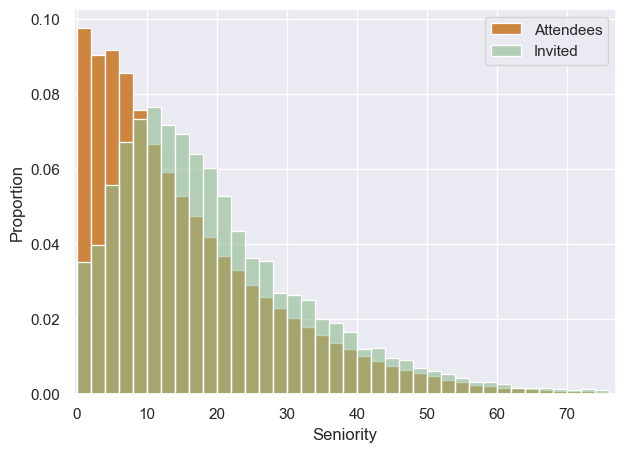

In [77]:
#distribution of seniority
sns.histplot(data = attendees, x = 'Seniority', stat = 'proportion', color = 'peru', label = 'Attendees', alpha = 1, binwidth = 2)
sns.histplot(data = invited, x = 'Seniority', stat = 'proportion', color = 'darkseagreen', label = 'Invited', alpha = 0.6, binwidth = 2)
plt.xlim(-0.5,77)
plt.legend()
plt.xlabel("Seniority", fontsize=12)
#plt.title("Distribution seniority for all researchers", fontsize = 15)
plt.savefig("Figures/seniorityDist_all.png", bbox_inches='tight')
plt.show()

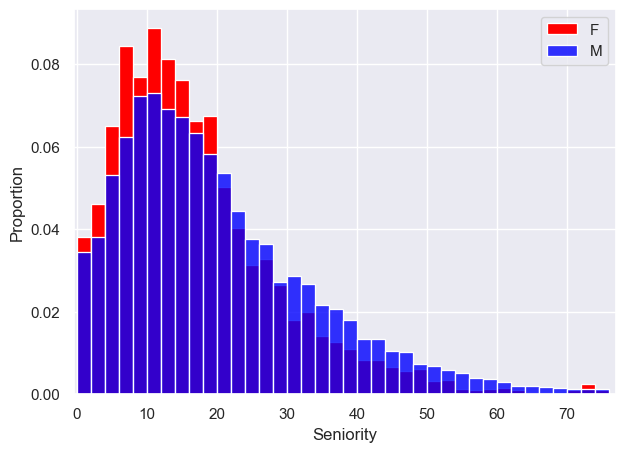

In [78]:
sns.histplot(data = femaleInv, x = 'Seniority', stat = 'proportion', color = 'red', label = 'F', alpha = 1, binwidth = 2)
sns.histplot(data = maleInv , x = 'Seniority', stat = 'proportion', color = 'blue', label = 'M', alpha = 0.8, binwidth = 2)
plt.xlim(-0.5,77)
plt.legend()
plt.xlabel("Seniority", fontsize=12)
#plt.title("Distribution seniority for invited speakers", fontsize = 15)
plt.savefig("Figures/seniorityDist_Invited.png", bbox_inches='tight')
plt.show()

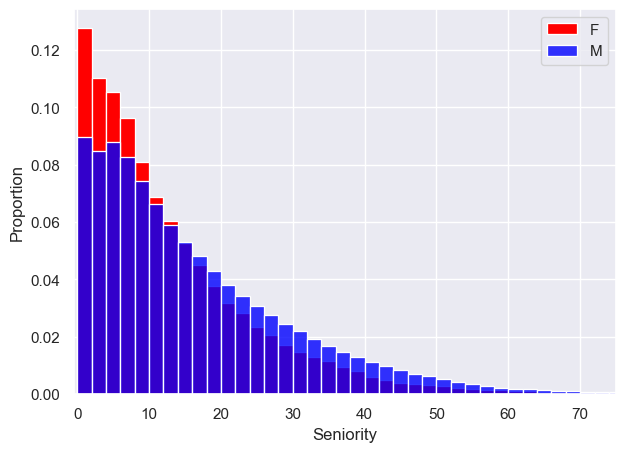

In [79]:
#note that the purple is just the red and purple overlapping
sns.histplot(data = femaleAtt, x = 'Seniority', stat = 'proportion', color = 'red', label = 'F', alpha = 1, binwidth = 2)
sns.histplot(data = maleAtt , x = 'Seniority', stat = 'proportion', color = 'blue', label = 'M', alpha = 0.8, binwidth = 2)
plt.legend()
plt.xlim(-0.5, 75)
plt.xlabel("Seniority", fontsize=12)
#plt.title("Distribution seniority for attendees", fontsize = 15)
plt.savefig("Figures/seniorityDist_Attendees.png", bbox_inches='tight')
plt.show()

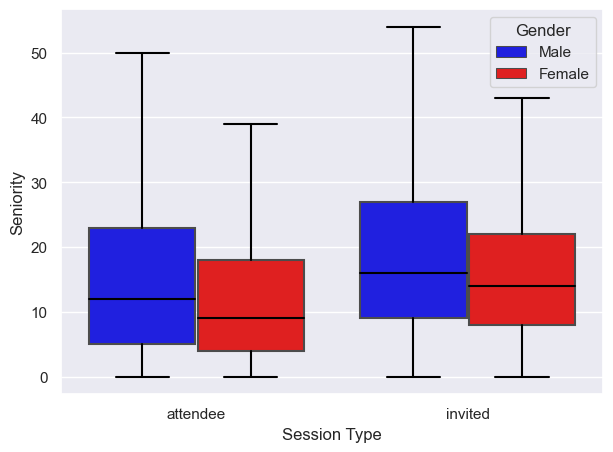

In [80]:
#boxplot of seniority
sns.boxplot(data=researchers , x="SessionType", y="Seniority", hue='Gender', palette = ['blue', 'red'], showfliers = False, medianprops=medianprops, whiskerprops = whiskerprops, capprops = capprops)
plt.xlabel("Session Type", fontsize=12)
plt.ylabel("Seniority", fontsize=12)
#plt.title("Boxplot of seniority", fontsize = 15)
plt.savefig("Figures/seniority_boxplot", bbox_inches='tight')
plt.show()

### Productivity

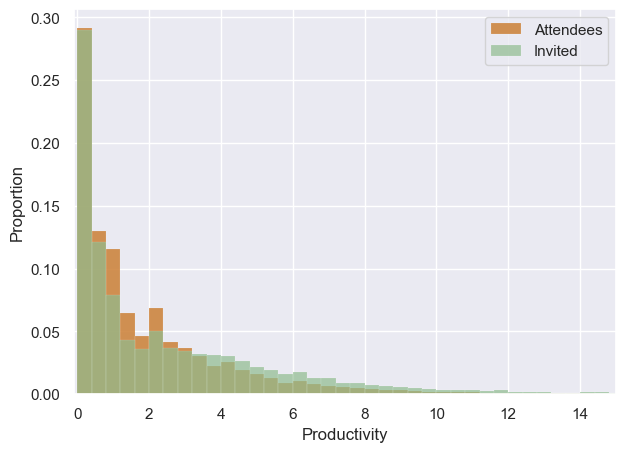

In [81]:
sns.histplot(data = attendees, x = 'Productivity', stat = 'proportion', color = 'peru', label = 'Attendees', binwidth = 0.4, alpha = 0.9)
sns.histplot(data = invited, x = 'Productivity', stat = 'proportion', color = 'darkseagreen', label = 'Invited', binwidth = 0.4, alpha = 0.7)
plt.legend()
plt.xlim(-0.1, 15)
#plt.title("Distribution productivity for all researchers", fontsize = 15)
plt.savefig("Figures/productivityDist_all.png", bbox_inches='tight')
plt.show()

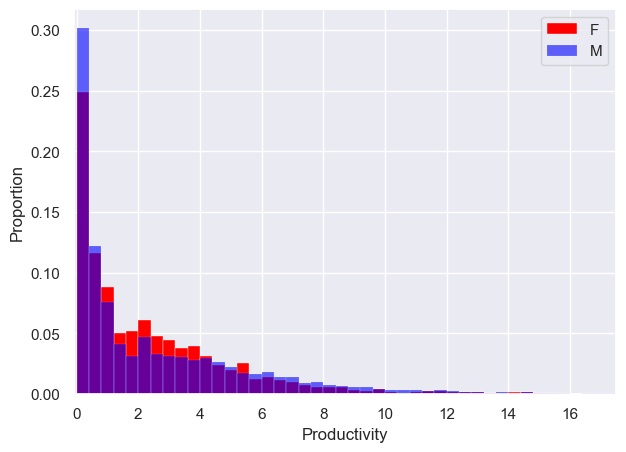

In [82]:
sns.histplot(data = femaleInv, x = 'Productivity', stat = 'proportion', color = 'red', label = 'F', binwidth = 0.4, alpha = 1)
sns.histplot(data = maleInv , x = 'Productivity', stat = 'proportion', color = 'blue', label = 'M', binwidth = 0.4, alpha = 0.6)
plt.legend()
plt.xlim(-0.1,17.5)
#plt.title("Distribution productivity for invited speakers", fontsize = 15)
plt.savefig("Figures/productivityDist_Invited.png", bbox_inches='tight')
plt.show()

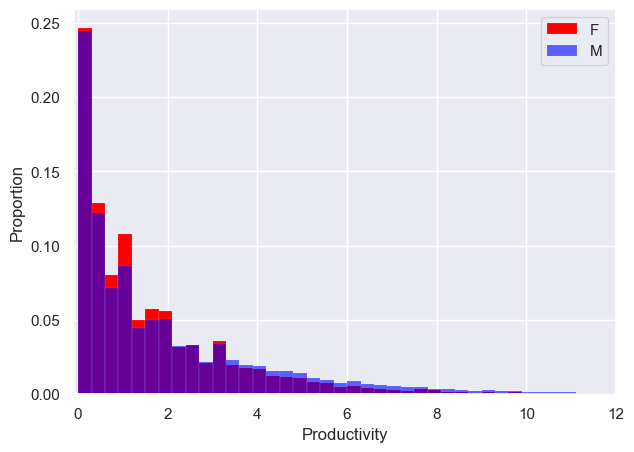

In [83]:
sns.histplot(data = femaleAtt, x = 'Productivity', stat = 'proportion', color = 'red', label = 'F', alpha = 1, binwidth = 0.3)
sns.histplot(data = maleAtt , x = 'Productivity', stat = 'proportion', color = 'blue', label = 'M', alpha = 0.6, binwidth = 0.3)
plt.legend()
plt.xlim(-0.1,12)
#plt.title("Distribution productivity for attendees", fontsize = 15)
plt.savefig("Figures/productivityDist_Attendees.png", bbox_inches='tight')
plt.show()

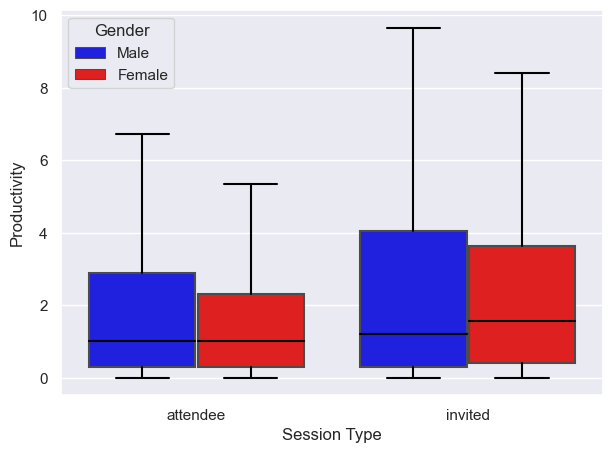

In [84]:
#productivity
sns.boxplot(data=researchers , x="SessionType", y="Productivity", hue='Gender', palette = ['blue', 'red'], showfliers = False, medianprops=medianprops, whiskerprops = whiskerprops, capprops = capprops)
plt.xlabel("Session Type", fontsize=12)
plt.ylabel("Productivity", fontsize=12)
#plt.title("Boxplot of log(productivity)", fontsize = 15)
plt.savefig("Figures/Productivity_boxplot", bbox_inches='tight')
plt.show()

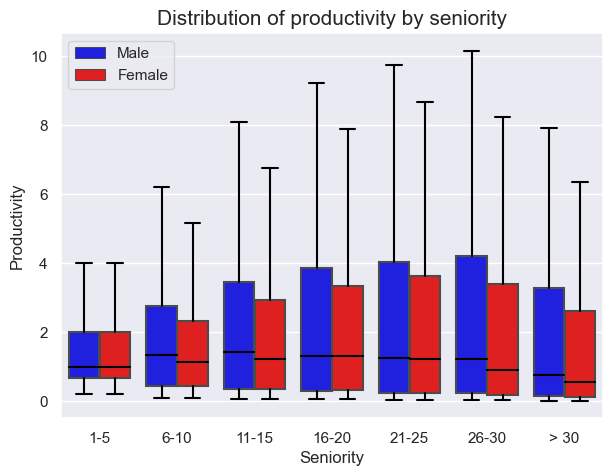

In [85]:
sns.boxplot(data=researchers , x="Seniority_cat", y='Productivity', hue='Gender', palette = ['blue', 'red'], showfliers = False, medianprops=medianprops, whiskerprops = whiskerprops, capprops = capprops)
plt.xlabel("Seniority", fontsize=12)
plt.ylabel("Productivity", fontsize=12)
plt.legend(loc="upper left")
plt.title("Distribution of productivity by seniority", fontsize = 15)
plt.savefig("Figures/productivity_Seniority_boxplot", bbox_inches='tight')
plt.show()

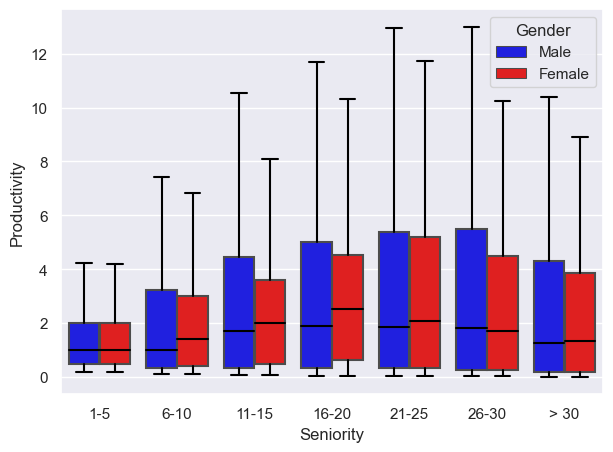

In [108]:
sns.boxplot(data=invited , x="Seniority_cat", y='Productivity', hue='Gender', palette = ['blue', 'red'], showfliers = False, medianprops=medianprops, whiskerprops = whiskerprops, capprops = capprops)
plt.xlabel("Seniority", fontsize=12)
plt.ylabel("Productivity", fontsize=12)
#plt.legend(loc="upper left")
#plt.title("Distribution of productivity by seniority", fontsize = 15)
plt.savefig("Figures/invitedProductivity_boxplot", bbox_inches='tight')
plt.show()

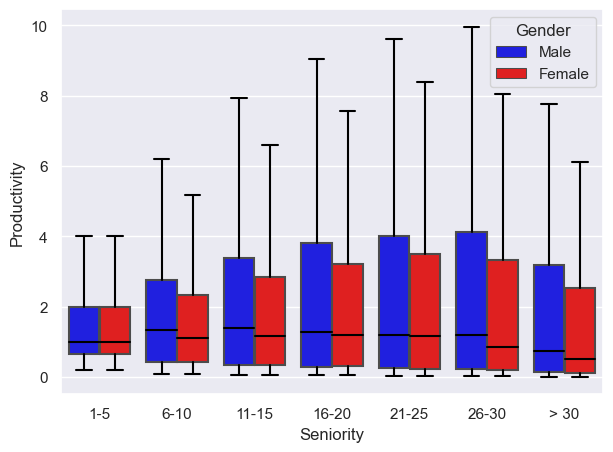

In [109]:
sns.boxplot(data=attendees , x="Seniority_cat", y='Productivity', hue='Gender', palette = ['blue', 'red'], showfliers = False, medianprops=medianprops, whiskerprops = whiskerprops, capprops = capprops)
plt.xlabel("Seniority", fontsize=12)
plt.ylabel("Productivity", fontsize=12)
#plt.legend(loc="upper left")
plt.savefig("Figures/attendeesProductivity_boxplot", bbox_inches='tight')
plt.show()